# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
import sys
sys.path.append('/Users/varesconkillian/opt/miniconda3/lib/python3.9/site-packages')

# Autograd & Numpy
import numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y

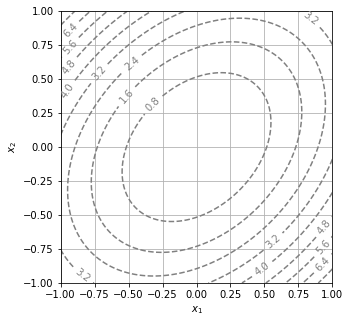

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

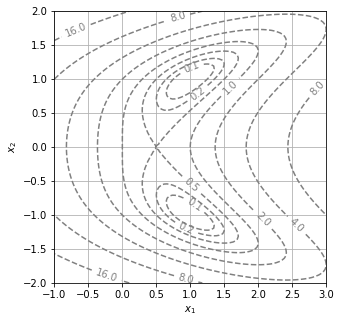

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

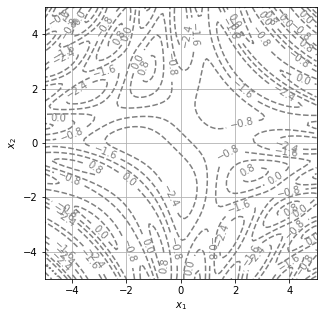

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [13]:
N = 100
eps = np.array([10**(-2)])

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [14]:
def Newton(F, x0, y0, eps=eps, N=N):
    jaq = J(F)
    x, y, dist = np.array(0.0), np.array(0.0), np.array(0.0)
    x0, y0 = np.array(x0), np.array(y0)
    
    for i in range(N):
        
        # on calcule l'inverse de la jacobienne au point (x0, y0)
        jaq_calc = numpy.linalg.inv(jaq(x0, y0))

        # d'après la formule du DL de f en (x, y} en faisant l'hypothèse f(x, y) = 0, on peut extraire x et y
        [x, y] = np.array([x0, y0]) - numpy.dot(jaq_calc, np.array(F(x0, y0)))
        dist = (np.sqrt((x - x0)**2 + (y - y0)**2))
                                                
        # si la distance entre le point précédent et le point courant est < eps, alors on converge effectivement
        # vers un point qui est environ (x, y), que l'on revoit
        if (dist <= eps).all():
            return [x, y]
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

def Funct_for_Newt(f, c):
    def F(x, y):
        return np.array([f(x, y) - c, y - x])
    return F

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.


[0.447250250297228, 0.447250250297228]


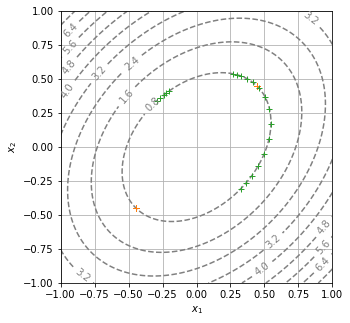

In [15]:
# on définie F1 telle que lorsque F1(x, y) = 0, on a x = y et f1(x, y) = 0.8

def F1(x, y):
    return np.array([f1(x, y) - 0.8, x - y])

# on appelle Newton() sur F1 en partant du point (0.8, 0.8)

print(Newton(F1, 0.8, 0.8))

# on fait varier le point de départ entre -0.9 et 0.9 et on étudie ce que renvoie Newton

x = np.linspace(-0.9, 0.9, 20)
result = [Newton(F1, y, y) for y in x]

# on obitnet 2 points oranges sur le graphe

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.plot(result, result, linestyle="None", marker="+")

# on se propose maintenant de faire varier la condition x = y en changeant F1
# pour cela on va modifier la condition en x = alpha * y, ou alpha prend ses valeurs entre -2 et 2
# on obtient une liste result2 contenant les coordonnées des points correspondants

alpha = np.linspace(-2., 2., 20)
result2 = []
for beta in alpha:
    def Falpha(x, y):
        return np.array([f1(x, y) - 0.8, x - beta * y])
    result2.append(Newton(Falpha, 0.8, 0.8))

result2 = np.array(result2)
    
plt.plot(result2[::,1], result2[::,0], linestyle="None", marker="+")

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

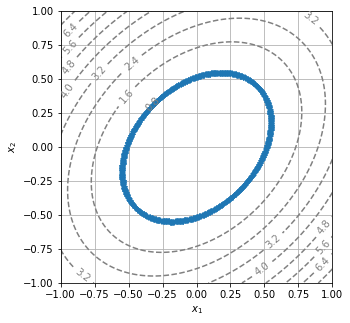

In [16]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    
    # on définit au départ quelques variables / fonctions comme le grad(f) ou le point de départ
    
    c = 0.8
    x0, y0 = np.array(x0), np.array(y0)
    result = [[x0, y0]]
    gradf = grad(f)
    
    # on définit une fonction distance entre 2 points pour plus de clarté
    
    def distance(pt_1, pt_2):
        return np.sqrt((pt_1[0] - pt_2[0])**2 + (pt_1[1] - pt_2[1])**2)
    
    # on définit une fonction orthograd() qui renvoie un vecteur unitaire orthogonal au gradien
    
    def orthograd(x, y):
        # la formule appliquée ici permet d'avoir le vecteur orthogonal :
        ortho_x, ortho_y = - gradf(x, y)[1], gradf(x, y)[0] 
        ortho = [ortho_x, ortho_y]
        return np.array(ortho / distance([0.0, 0.0], ortho))
    
    def cercle(x, y):
        return (y - y0)**2 + (x - x0)**2 - delta**2
    
    # on définit la fonction F qui est telle que lorsque F(x, y) = 0 :
    # f(x, y) = c ET cercle(x, y) = 0 : i.e. x, y appartient au cercle de rayon delta
    
    def F(x, y):
        x, y = np.array(x), np.array(y)
        return np.array([f(x, y) - c, cercle(x, y)])
    
    # on définit la nouvelle methode de Newton adaptée :
    # celle ci ne s'arrête plus au bout d'un nombre fini d'itération
    # elle se poursuit jusqu'a converger (si convergence il y a)
    
    # le principe est le suivant :
    # on part d'un point décalé dans le demi plan à droite du grad(x0, y0)
    # ce point de départ est donc à la distance delta dans la direction orthogonale au gradien
    # ensuite on procéde simplement à la résolution par la méthode de Newton
    # de l'équation F(x, y) = 0
    
    def Newton2(F, x0, y0, eps=eps, N=N):
        
        x0, y0 = np.array(x0), np.array(y0)
        vec0 = np.array([x0, y0])
        orthograd0 = orthograd(x0 ,y0)
        [x1, y1] = vec0 + delta * orthograd0
       
        dist = np.array(delta)
            
        jaq = J(F)
                
        while (dist >= eps).all():
            jaq_calc = np.linalg.inv(jaq(x1, y1))
            vec = np.array([x1, y1]) - numpy.dot(jaq_calc, np.array(F(x1, y1)))
            prod = np.dot(vec, orthograd0)
            dist = distance(vec, [x1, y1])
            if (dist <= eps).all():
                return vec
            x1, y1 = vec[0], vec[1]
    
    # on effectue le calcul pour N - 1 points pour finalement avoir une liste de N points
    
    for k in range(N - 1):
        x0, y0 = result[k]
        resultk = Newton2(F, x0, y0)
        result.append(resultk)
        
    return np.array(result)


x_d, y_d = Newton(F1, 0.8, 0.8)

result = level_curve(f1, x_d, y_d)

plt.close()

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.plot(result[::,0], result[::,1] ,linestyle="None", marker="+")

plt.show()


### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

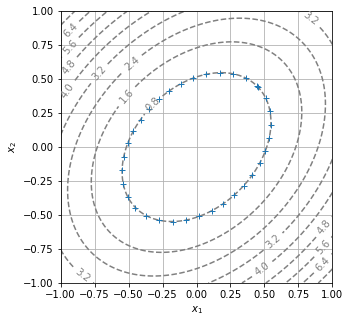

In [17]:
def level_curve_updated(f, x0, y0, c=0.8, delta=0.1, N=1000, eps=eps):
    
    # on définit au départ quelques variables / fonctions comme le grad(f) ou le point de départ
    
    x0, y0 = np.array(x0), np.array(y0)
    result = [[x0, y0]]
    gradf = grad(f)
    
    # on définit une fonction distance entre 2 points pour plus de clarté
    
    def distance(pt_1, pt_2):
        return np.sqrt((pt_1[0] - pt_2[0])**2 + (pt_1[1] - pt_2[1])**2)
    
    # on définit une fonction orthograd() qui renvoie un vecteur unitaire orthogonal au gradien
    
    def orthograd(x, y):
        # la formule appliquée ici permet d'avoir le vecteur orthogonal :
        ortho_x, ortho_y = - gradf(x, y)[1], gradf(x, y)[0] 
        ortho = [ortho_x, ortho_y]
        return np.array(ortho / distance([0.0, 0.0], ortho))
    
    def cercle(x, y):
        return (y - y0)**2 + (x - x0)**2 - delta**2
    
    # on définit la fonction F qui est telle que lorsque F(x, y) = 0 :
    # f(x, y) = c ET cercle(x, y) = 0 : i.e. x, y appartient au cercle de rayon delta
    
    def F(x, y):
        x, y = np.array(x), np.array(y)
        return np.array([f(x, y) - c, cercle(x, y)])
    
    # on définit la nouvelle methode de Newton adaptée :
    # celle ci ne s'arrête plus au bout d'un nombre fini d'itération
    # elle se poursuit jusqu'a converger (si convergence il y a)
    
    # le principe est le suivant :
    # on part d'un point décalé dans le demi plan à droite du grad(x0, y0)
    # ce point de départ est donc à la distance delta dans la direction orthogonale au gradien
    # ensuite on procéde simplement à la résolution par la méthode de Newton
    # de l'équation F(x, y) = 0
    
    def Newton2(F, x0, y0, eps=eps, N=N):
        
        x0, y0 = np.array(x0), np.array(y0)
        vec0 = np.array([x0, y0])
        orthograd0 = orthograd(x0 ,y0)
        [x1, y1] = vec0 + delta * orthograd0
       
        dist = np.array(delta)
            
        jaq = J(F)
                
        while (dist >= eps).all():
            jaq_calc = np.linalg.inv(jaq(x1, y1))
            vec = np.array([x1, y1]) - numpy.dot(jaq_calc, np.array(F(x1, y1)))
            prod = np.dot(vec, orthograd0)
            dist = distance(vec, [x1, y1])
            if (dist <= eps).all():
                return vec
            x1, y1 = vec[0], vec[1]
    
    # on effectue le calcul pour N - 1 points pour finalement avoir une liste de N points
    
        
    for k in range(N - 1):
        x0, y0 = result[k]
        resultk = Newton2(F, x0, y0)
        result.append(resultk)
        
        # on ajoute une clause telle qui si jamais le nouveau point est "trop"
        # proche du point de départ, on arrête de calculer des nouveaux points
        # car cela signifie que l'on a fait le tour de la courbe.
        
        if distance(resultk, result[0]) <= delta / 2:
            break
        
    return np.array(result)


x_d, y_d = Newton(F1, 0.8, 0.8)
result = level_curve_updated(f1, x_d, y_d)

plt.close()

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100),
    levels=10 # 10 levels, automatically selected
)
plt.plot(result[::,0], result[::,1] ,linestyle="None", marker="+")
plt.show()


# on constate effectivement que l'on a bien un nombre de points
# inférieurs à N

-1.6155279613885469e-12 -1.6155279613885469e-12


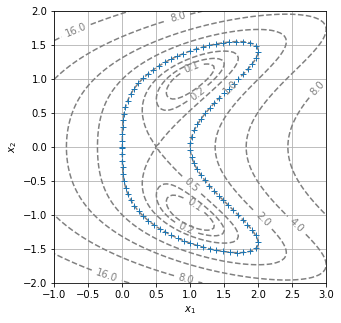

In [18]:
F2 = Funct_for_Newt(f2, c=1.)
x_d, y_d = Newton(F2, 0.5, 0.5, N=1000, eps=10**-3)
print(x_d, y_d)
result = level_curve_updated(f2, x_d, y_d, c=1.)
plt.close()

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

plt.plot(result[::,0], result[::,1], linestyle="None", marker="+")
plt.show()




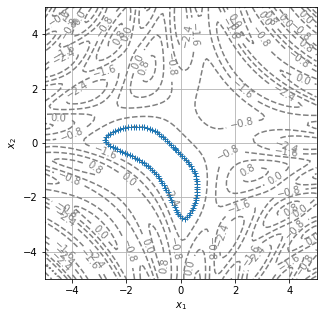

In [19]:
def F3(x, y):
    return np.array([f3(x, y) + 2.4, x - y])

x_d, y_d = Newton(F3, 0.1, 0.1, N=1000, eps=10**-3)

result = level_curve_updated(f3, x_d, y_d, c=-2.4)

plt.close()

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

plt.plot(result[::,0], result[::,1], linestyle="None", marker="+")
plt.show()




**Question** Valider graphiquement le résultat au moyen des exemples de référence.

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

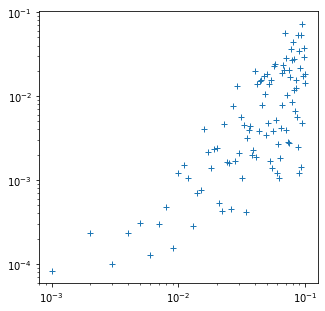

In [20]:
def area_squares(f, c, h):
    x = np.arange(-2, 2, h)
    y = np.arange(-2, 2, h)
    n = int((y[-1] - y[0]) // h)
    A_h = 0
    
    for i in range(n):
        for j in range(n):
            x_mid = x[i] + h / 2
            y_mid = y[j] + h / 2
            if f(x_mid, y_mid) <= c:
                A_h += (h ** 2)
    
    return A_h

def f0(x, y):
    return (x ** 2 + y ** 2) 
    
h_list = np.linspace(0.001, 0.1, 100)
result = [(abs(np.pi - area_squares(f0, 1, h))) for h in h_list]

plt.close()
plt.loglog(h_list, result, linestyle="None", marker="+")
plt.show()

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [21]:
# Comme la surface du disque unité est exactement connue, il suffit de se servir de la fonction précédente pour que 

def area_finder(f, c, eps=10**-2):
    
    h = 0.1
    error = 1
    
    def area_squares(f, c, h):
        x = np.arange(-3, 3, h)
        y = np.arange(-3, 3, h)
        n = int((y[-1] - y[0]) // h)
        A_h = 0

        for i in range(n):
            for j in range(n):
                x_mid = x[i] + h / 2
                y_mid = y[j] + h / 2
                if f(x_mid, y_mid) <= c:
                    A_h += (h ** 2)

        return A_h
    
    def f0(x, y):
        return (x ** 2 + y ** 2) 
    
    while error >= eps:
        h = h / 2
        A_h = area_squares(f0, 1, h)
        error = abs(np.pi - A_h)
    
    A_h = area_squares(f, c, h)
    borne_inf = round(A_h - 10**-2, 2)
    borne_max = round(A_h + 10**-2, 2)
    
    return f"L'aire recherchée est comprise entre {borne_inf} et {borne_max}"
    


area_finder(f1, 0.8)

"L'aire recherchée est comprise entre 0.88 et 0.9"

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

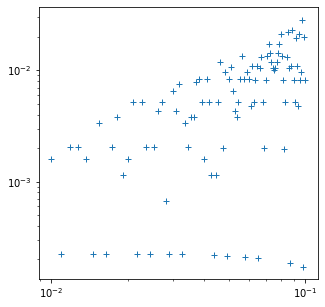

In [22]:
def area_triangles(ensemble_points, p=(0.,0.)):
    
    x_mean = sum(ensemble_points[::,0]) / len(ensemble_points[::,0])
    y_mean = sum(ensemble_points[::,1]) / len(ensemble_points[::,1])
    p = (x_mean, y_mean)
    
    A = 0
    z0 = ensemble_points[0]
    
    
    def aire_triangle(s1, s2):
        vec1 = s1 - p
        vec2 = s2 - p
        return 0.5 * abs(vec1[0] * vec2[1] - vec1[1] * vec2[0])

    
    for z in ensemble_points:
        A += aire_triangle(z, z0)
        z0 = z
        
    
    return A

def f_cercle(x, y):
    x = np.array(x)
    y = np.array(y)
    return (x ** 2) + (y ** 2)

#result = level_curve_updated(f_cercle, 1., 0., c=1.)


#area_triangles(result)

    
delta_list = np.linspace(0.01, 0.1, 100)
result = [(abs(np.pi - area_triangles(level_curve_updated(f_cercle, 1., 0., c=1., delta=deltaprime)))) for deltaprime in delta_list]

plt.close()
plt.loglog(delta_list, result, linestyle="None", marker="+")
plt.show()

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [23]:
def area_triangles(ensemble_points):
    
    p = (0., 0.)
    
    A = 0
    z0 = ensemble_points[0]
    
    
    def aire_triangle(s1, s2):
        vec1 = s1 - p
        vec2 = s2 - p
        return 0.5 * (vec1[0] * vec2[1] - vec1[1] * vec2[0])

    
    for z in ensemble_points:
        A += aire_triangle(z, z0)
        z0 = z
        
    
    return - A

def f_cercle(x, y):
    x = np.array(x)
    y = np.array(y)
    return (x - 1)** 2 + (y - 1)** 2

area_triangles(level_curve_updated(f_cercle, 1., 0., c=1., delta = 0.01))

# en changeant p même en dehors du cercle (ce qui est le cas ici, car le cercle est centré en (1,1)),
# on obtient toujours pi
# Cela s'explique ainsi : on mesure l'aire du cercle plus celle extérieure au cercle et formant un triangle
# dont deux des sommets sont aux extrémités d'un diamètre du cercle, et le dernier est le point p.
# Lorsque le calcul se poursuit, comme on tourne dans le sens horraire, et que l'on finit par se diriger vers le point
# de départ, on calcule des aires négatives. Ces aires la se soustraient aux aires supplémentaires du triangle
# compté en trop, et on obtient à la fin l'aire seule du cercle (cf dessin.pdf). Sur le dessin, on voit que
# l'on compte les aires jaunes positivement, puis on compte négativement les aires rouges : finalement,
# il ne reste que l'aire dans le cercle.

3.1415426952756373

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [24]:
# On définit deux disques unités centrés en (2,2) et en (-2, -2)

def f_cercle1(x, y):
    x = np.array(x)
    y = np.array(y)
    return (x - 2)** 2 + (y - 2)** 2

def f_cercle2(x, y):
    x = np.array(x)
    y = np.array(y)
    return (x + 2)** 2 + (y + 2)** 2


contour1 = level_curve_updated(f_cercle1, 2., 1., c=1., delta = 0.01)
contour2 = level_curve_updated(f_cercle2, -2., -1., c=1., delta = 0.01)

# on a donc un enseble de 2 disques disjoints donc un ensemble non convexe

contour_tot = np.concatenate((contour1, contour2))

print(2 * np.pi - area_triangles(contour_tot))

# on obtient bien quelque chose de presque nul, donc le calcul reste correcte

-0.004530529406198802


**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [25]:
def area_triangles(ensemble_points):
    
    p = (0., 0.)
    
    A = 0
    z0 = ensemble_points[0]
    
    
    def aire_triangle(s1, s2):
        vec1 = s1 - p
        vec2 = s2 - p
        return 0.5 * (vec1[0] * vec2[1] - vec1[1] * vec2[0])

    
    for z in ensemble_points:
        A += aire_triangle(z, z0)
        z0 = z
        
    
    return - A

def f_cercle1(x, y):
    x = np.array(x)
    y = np.array(y)
    return (x - 2)** 2 + (y - 2)** 2

def f_cercle2(x, y):
    x = np.array(x)
    y = np.array(y)
    return (x + 2)** 2 + (y + 2)** 2

def f_double(x, y):
    x = np.array(x)
    y = np.array(y)
    if x < 0 and y < 0:
        return (x + 2)** 2 + (y + 2)** 2
    else:
        return (x - 2)** 2 + (y - 2)** 2



F_c1 = Funct_for_Newt(f_cercle1, c=1.)
F_c2 = Funct_for_Newt(f_cercle2, c=1.)

x0, y0 = Newton(F_c1, 2., 1.)
x0prime, y0prime = Newton(F_c2, -1., -2.)
x1, y1 = Newton(F1, 0.8, 0.8)

contour1 = level_curve_updated(f0, 0., 1., c=1., delta = 0.01)
contour2 = level_curve_updated(f1, x1, y1, c=0.8)

contour3 = level_curve_updated(f_cercle1, x0, y0, c=1.)
contour4 = level_curve_updated(f_cercle2, x0prime, y0prime, c=1.)


contour_tot = np.concatenate((contour3, contour4))

print(area_finder(f_double, 1.))

# points négatifs de la méthode des carrés : elle nécéssite de générer un grand carré , qui potentiellement
# entraine la création de sous carrés de coté h qui sont inutiles car loin du domaine considéré : si on imagine
# un rectangle de largeur delta et de longueur L >> delta qui serait orienté selon la première bissectrice,
# on est obligé de calculer un nombre de petits carrés de coté delta pour rien.
# Au contraire, la méthode des triangles y serait bien plus efficace, à condition que le contour ne contienne
# pas un trop grand nombre de points.


L'aire recherchée est comprise entre 6.23 et 6.25


In [26]:
import time, statistics

measures = []
for i in range(100):
    start = time.time()
    
    (area_triangles(contour_tot))

    
    end = time.time()
    measures.append(end - start)

mean = statistics.mean(measures)
stdev = statistics.stdev(measures)

print('Temps d\'exécution :')
print(f' - Moyenne : {mean:.1}ms')
print(f' - Écart-type : {stdev:.1}ms')

Temps d'exécution :
 - Moyenne : 0.0004ms
 - Écart-type : 1e-05ms


In [27]:
import time, statistics

measures = []
for i in range(100):
    start = time.time()
    
    area_finder(f_double, 1.)

    
    end = time.time()
    measures.append(end - start)

mean = statistics.mean(measures)
stdev = statistics.stdev(measures)

print('Temps d\'exécution :')
print(f' - Moyenne : {mean:.1}ms')
print(f' - Écart-type : {stdev:.1}ms')

Temps d'exécution :
 - Moyenne : 0.5ms
 - Écart-type : 0.006ms


In [28]:
# On constate que le calcul est notablement plus long dans ce cas là avec la méthode des carrés